Extract data from a DAO NetCDF file

In [65]:
import numpy as np
import xarray as xr

In [66]:
ds = xr.open_dataset("/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/data/dao.80_93.nc")

In [67]:
if ds.coords["level"].isnull().all():
    print("Fixing broken pressure level data")
    levels = [1000.0, 950.0, 900.0, 850.0, 700.0, 500.0, 300.0, 200.0]
    ds.coords["level"] = xr.DataArray(levels, dims=["level"], coords={"level": levels}, attrs={"units": "hPa"})

Fixing broken pressure level data


In [68]:
# make sure lat runs from south to north
if not ds["lat"].to_index().is_monotonic_increasing:
    print("flipping lat")
    ds = ds.sortby("lat", ascending=True)

flipping lat


In [69]:
# make sure lon runs from west to east
if not ds["lon"].to_index().is_monotonic_increasing:
    print("flipping lon")
    ds = ds.sortby("lon", ascending=True)

In [70]:
# get a spatial subset 4°N–16°S, 50°–76°W
ds = ds.sel(lat=slice(-16, 4), lon=slice(-76, -50))

In [71]:
# make sure that the order of the dimensions is (lon, lat, ...) for all variables
ds = ds.transpose("lon", "lat", ...)

In [72]:
# grab the first time step
# should be Jan 1980
ds = ds.isel(time=0, drop=True)

In [73]:
import bulk_recycling_model.numerical_integration

In [74]:
# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.numerical_integration.integrate_no_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

In [75]:
# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.numerical_integration.integrate_no_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

Prepare and scale the data

In [76]:
from bulk_recycling_model import preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

In [77]:
# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

In [78]:
# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

In [79]:
# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

In [80]:
# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

In [81]:
print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")

L = 2.87e+06 m
dx = 2.05e+05 m
H = 2.22e+06 m
dy = 2.02e+05 m


In [82]:
# make a scaling object to convert between unit systems
scaling = Scaling(H)

In [83]:
dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

dx = 9.23e-02 scaled
dy = 9.09e-02 scaled


In [84]:
# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

In [85]:
# preprocess water vapor fluxes onto the secondary grid
Fx_left = preprocess.prepare_Fx_left(Fx)
Fx_right = preprocess.prepare_Fx_right(Fx)
Fy_bottom = preprocess.prepare_Fy_bottom(Fy)
Fy_top = preprocess.prepare_Fy_top(Fy)

In [86]:
# convert E to scaled units
E = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)

In [87]:
# preprocess E onto the secondary grid
E = preprocess.prepare_E(E)

In [88]:
# compute P
P = preprocess.calculate_precipitation(Fx_left, Fx_right, Fy_bottom, Fy_top, E, dx, dy)

Run the model

In [89]:
import matplotlib.pyplot as plt

In [90]:
import logging

logging.basicConfig()
logging.getLogger("bulk_recycling_model").setLevel(logging.INFO)

In [91]:
from bulk_recycling_model import plotting
from bulk_recycling_model.main import run

In [92]:
class Callback:
    def __init__(self):
        self.n_calls = 0  # number of times callback has executed

    def __call__(self, rho: np.ndarray, k: int):
        fig, ax = plt.subplots()
        collection = plotting.pcolormesh(ax, rho, lon_axis, lat_axis, vmin=0.0, vmax=0.8)
        fig.colorbar(collection)
        fig.suptitle(f"$\\rho^k$ @ k={k:04d}")
        plt.savefig(f"plots/{self.n_calls:05d}_{k:04d}.png")
        plt.close(fig)
        self.n_calls += 1

In [93]:
! rm plots/*.png

zsh:1: no matches found: plots/*.png


In [94]:
status = run(
    Fx_left,
    Fx_right,
    Fy_bottom,
    Fy_top,
    E,
    P,
    dx,
    dy,
    tol=1e-2,
    #callback=Callback(),
)
assert status["success"]

INFO:bulk_recycling_model.main:Iteration 1 of 1000. Finished in 0.000742 seconds
INFO:bulk_recycling_model.main:Iteration 1 of 1000. delta = 0.09379119784633923
INFO:bulk_recycling_model.main:Iteration 2 of 1000. Finished in 0.000448 seconds
INFO:bulk_recycling_model.main:Iteration 2 of 1000. delta = 0.0864831046342787
INFO:bulk_recycling_model.main:Iteration 3 of 1000. Finished in 0.000474 seconds
INFO:bulk_recycling_model.main:Iteration 3 of 1000. delta = 0.07894973491983193
INFO:bulk_recycling_model.main:Iteration 4 of 1000. Finished in 0.000465 seconds
INFO:bulk_recycling_model.main:Iteration 4 of 1000. delta = 0.07143267110843127
INFO:bulk_recycling_model.main:Iteration 5 of 1000. Finished in 0.000466 seconds
INFO:bulk_recycling_model.main:Iteration 5 of 1000. delta = 0.06411291545204018
INFO:bulk_recycling_model.main:Iteration 6 of 1000. Finished in 0.000466 seconds
INFO:bulk_recycling_model.main:Iteration 6 of 1000. delta = 0.057121522094402744
INFO:bulk_recycling_model.main:Ite

Animate the plots using ffmpeg

```bash
ffmpeg -framerate 30 -pattern_type glob -i "*.png" -vf "tpad=stop_mode=clone:stop_duration=3" -c:v libx264 -pix_fmt yuv420p mov.mp4
```

Text(0.5, 0.98, '$\\rho$')

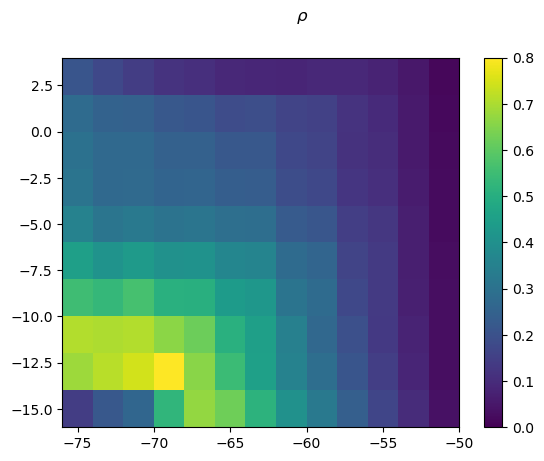

In [95]:
# plot the final solution
rho = status["rho"]
fig, ax = plt.subplots()
collection = plotting.pcolormesh(ax, rho, lon_axis, lat_axis, vmin=0.0, vmax=0.8)
fig.colorbar(collection)
fig.suptitle("$\\rho$")

Text(0.5, 0, 'Iteration')

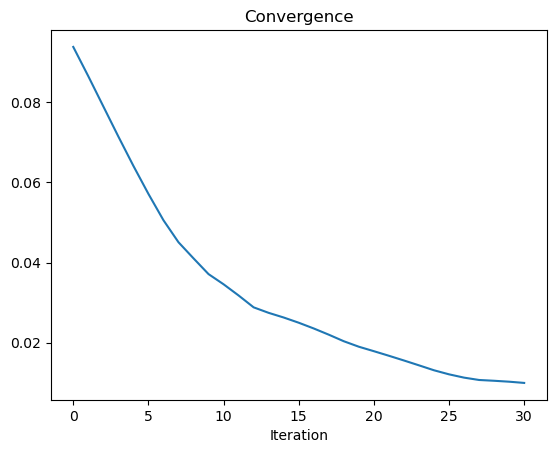

In [96]:
# plot the convergence
deltas = status["deltas"]
fig, ax = plt.subplots()
ax.plot(deltas)
ax.set_title("Convergence")
ax.set_xlabel("Iteration")